# Assignment 3: Training large AI models

Please submit this file to Canvas by 23:59 on 3 Mar.

Finish 4 tasks according to the instructions. Only change the code in the required area and DO NOT change others or add new code/text snippets.

Rename this file as "Student_number.ipynb". e.g., 'A0000000J.ipynb'.

Submit the file to /Files/assignments/submission/assignment3. You can only submit the files once.

Please follow the instructions strictly, otherwise you might be penalized.

If you has any questions, please propose it on Slack (preferred), or contact Fuzhao Xue (f.xue@u.nus.edu).

In [1]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
! pip install colossalai timm tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 674.4/674.4 KB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.2/202.2 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 KB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.8/210.8 KB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 KB 14.2 MB/s eta 0:00:00
     ━━━━━

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from colossalai.nn.parallel import GeminiDDP
from colossalai.nn.optimizer.gemini_optimizer import GeminiAdamOptimizer
from colossalai.utils import get_current_device
from colossalai.utils.model.colo_init_context import ColoInitContext

/usr/local/lib/python3.8/dist-packages/torch/library.py:130: UserWarning: Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: aten::index.Tensor(Tensor self, Tensor?[] indices) -> Tensor
    registered at aten/src/ATen/RegisterSchema.cpp:6
  dispatch key: Meta
  previous kernel: registered at ../aten/src/ATen/functorch/BatchRulesScatterOps.cpp:1053
       new kernel: registered at /dev/null:219 (Triggered internally at ../aten/src/ATen/core/dispatch/OperatorEntry.cpp:150.)
  self.m.impl(name, dispatch_key, fn)


## Install cache

In [4]:
# if your code stucks in 
# =========================================================================================
# No pre-built kernel is found, build and load the cpu_adam kernel during runtime now
# =========================================================================================
# Restart the colab and run the following line can help.

! rm -rf ~/.cache/colossalai/torch_extensions

In [5]:
# this is only needed in colab as colab provides limited CPU memory
# runtime compilation will trigger the out-of-memory issue

from colossalai.kernel.op_builder import CPUAdamBuilder, FusedOptimBuilder
import os
os.environ['MAX_JOBS'] = '4'
CPUAdamBuilder().load() # this may be slow and it can take several minutes
FusedOptimBuilder().load() # this may be slow and it can take several minutes

No pre-built kernel is found, build and load the cpu_adam kernel during runtime now


Emitting ninja build file /root/.cache/colossalai/torch_extensions/torch1.13_cu11.6/build.ninja...
Building extension module cpu_adam...
Using envvar MAX_JOBS (4) as the number of workers...


Time to load cpu_adam op: 40.62804651260376 seconds
No pre-built kernel is found, build and load the fused_optim kernel during runtime now


Loading extension module cpu_adam...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/colossalai/torch_extensions/torch1.13_cu11.6/build.ninja...
Building extension module fused_optim...
Using envvar MAX_JOBS (4) as the number of workers...


Time to load fused_optim op: 251.99906754493713 seconds


Loading extension module fused_optim...


<module 'fused_optim' from '/root/.cache/colossalai/torch_extensions/torch1.13_cu11.6/fused_optim.so'>

Initialize the distributed backend

In [6]:
import colossalai
colossalai.launch(config={}, rank=0, world_size=1, host='localhost', port=29500)

[02/16/23 11:03:30] INFO     colossalai - colossalai - INFO:                                                       
                             /usr/local/lib/python3.8/dist-packages/colossalai/context/parallel_context.py:521     
                             set_device

                    INFO     colossalai - colossalai - INFO: process rank 0 is bound to device 0

[02/16/23 11:03:35] INFO     colossalai - colossalai - INFO:                                                       
                             /usr/local/lib/python3.8/dist-packages/colossalai/context/parallel_context.py:557     
                             set_seed

                    INFO     colossalai - colossalai - INFO: initialized seed on rank 0, numpy: 1024, python       
                             random: 1024, ParallelMode.DATA: 1024, ParallelMode.TENSOR: 1024,the default parallel 
                             seed is ParallelMode.DATA.

                    INFO     colossalai - colossalai - INFO:                                                       
                             /usr/local/lib/python3.8/dist-packages/colossalai/initialize.py:116 launch

                    INFO     colossalai - colossalai - INFO: Distributed environment is initialized, data parallel 
                             size: 1, pipeline parallel size: 1, tensor parallel size: 1

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batch size = 128 by default
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



 ship  deer   car truck


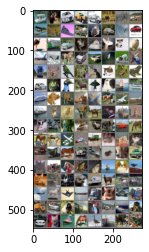

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network


In [9]:
import torch.nn as nn
import torch.nn.functional as F
from timm.models.rexnet import rexnet_100, rexnet_200

class HugeModel(torch.nn.Module):

    def __init__(self, rexnet = None):
        super(HugeModel, self).__init__()

        self.rexnet = rexnet
        self.activation = torch.nn.ReLU()
        self.linear1 = torch.nn.Linear(10, 4096)
        self.linear2 = torch.nn.Linear(4096, 4096)
        self.linear3 = torch.nn.Linear(4096, 4096)
        self.linear4 = torch.nn.Linear(4096, 10240)
        self.linear5 = torch.nn.Linear(10240, 10240)
        self.linear6 = torch.nn.Linear(10240, 10)

    def forward(self, x):
        x = self.rexnet(x)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        x = self.linear3(x)
        x = self.activation(x)
        x = self.linear4(x)
        x = self.activation(x)
        x = self.linear5(x)
        x = self.activation(x)
        x = self.linear6(x)
        return x

# Do not use huge model by default.
use_hugemodel = False
with ColoInitContext(device=get_current_device()):
    net = rexnet_200(num_classes=10, pretrained=True)

    # Use larger model for task 3.
    if use_hugemodel:
      net = HugeModel(net)

[02/16/23 11:03:45] INFO     colossalai - ProcessGroup - INFO:                                                     
                             /usr/local/lib/python3.8/dist-packages/colossalai/tensor/process_group.py:22          
                             log_pg_init

                    INFO     colossalai - ProcessGroup - INFO: Pytorch ProcessGroup Init:                          
                                     backend: nccl                                                                 
                                     ranks: [0]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rexnet/rexnetv1_200-8c0b7f2d.pth" to /root/.cache/torch/hub/checkpoints/rexnetv1_200-8c0b7f2d.pth


3. Define a Loss function and optimizer. Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

In [11]:
placement = 'cuda' # can be cpu, auto and cuda
net = GeminiDDP(net,
                device=get_current_device(),
                placement_policy=placement,
                search_range_mb=64)

optimizer = GeminiAdamOptimizer(net, lr=1e-3, initial_scale=2**5)

searching chunk configuration is completed in 0.01 s.
used number: 13.19 MB, wasted number: 0.00 MB
total wasted percentage is 0.00%
No pre-built kernel is found, build and load the cpu_adam kernel during runtime now
Time to load cpu_adam op: 0.04873085021972656 seconds
No pre-built kernel is found, build and load the fused_optim kernel during runtime now
Time to load fused_optim op: 0.0026547908782958984 seconds


No modifications detected for re-loaded extension module cpu_adam, skipping build step...
Loading extension module cpu_adam...
No modifications detected for re-loaded extension module fused_optim, skipping build step...
Loading extension module fused_optim...


4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [12]:
from tqdm import tqdm

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.backward(loss)
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

100%|██████████| 391/391 [01:53<00:00,  3.44it/s]

Finished Training


5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [13]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

GroundTruth:    cat  ship  ship plane


Okay, now let us see what the neural network thinks these examples above are:



In [14]:
images = images.cuda()
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 80 %


# Task 1: Playing Batch Size

First of all, after connecting the GPU, you will be able to see the System RAM and GPU RAM usage after clicking the RAM logo at the upper-right corner on Colab.

Then, let's do our first task:

The current batch size should be 128, please sweep the batch size over [16, 128, 1024]. And write down what you observed. 

1) For larger batch size, training is faster or slower? (1 mark)

2) When training with larger batch size, the total computation cost (Total FLOPs) is higher, lower, or equal? Why? (1 mark)

3) Based on the findings in (1) and (2), why training with larger batch size is faster or slower? (1 mark)


In [17]:
'''
Write down your answers for Task 1 here:
1)
2)
3)

'''

'\nWrite down your answers for Task 1 here:\n1)\n2)\n3)\n\n'

# Task 2 Playing larger model

Let's fix the batch size as 1024 from now.

We are using rexnet_100 now. Please use rexnet_200 instead of rexnet_100 for task 2, and train again. 

Note: Restart in Runtime when run different options. This would help to ensure your result is correct.

1) Please tell me what about the speed now. Faster or slower? Why？? (1 mark)

2) What about the GPU RAM usage now? Using larger GPU RAM than RexNet-100 or not? Why? (1 mark)

RexNet paper: https://aps.arxiv.org/abs/2007.00992v1


In [18]:
'''
Write down your answers for Task 2 here:
1)
2)

'''

'\nWrite down your answers for Task 2 here:\n1)\n2)\n\n'

# Task 3 Playing Memory Management

Let's set batch size as 128 and set use_hugemodel=True as the pre-trained model in task 3.

We have three options for placement_policy of GeminiDDP (cuda, cpu, auto). Try these three options and answer the following questions:

Note: Restart in Runtime when run different options. This would help to ensure your result is correct.

1) Compare the speed (seconds per epoch) of different placement_policy? (1 mark) 

2) Compare the System RAM and GPU RAM usage (GB). Explain why. (1 mark)

2) Let's ignore auto mode. When shall we use cuda and when shall we use cpu? (1 mark)

In [19]:
'''
Write down your answers for Task 3 here:
1)
2)
3) 

'''

'\nWrite down your answers for Task 3 here:\n1)\n2)\n3) \n\n'